In [ ]:
from google.colab import drive

# Attempt to mount Drive, handling potential authentication issues
try:
  drive.mount('/content/drive')
except Exception as e:
  print(f"An error occurred during mount: {e}")
  # Provide guidance or instructions for manual authentication if needed
  print("Please follow the authentication steps in the output above.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip  install matplotlib
%pip  install  torch torchvision
%pip install pyopencl
%pip install torchinfo
%pip install tqdm

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_dir='/content/drive/MyDrive/train'
test_dir='/content/drive/MyDrive/test'
valid_dir='/content/drive/MyDrive/valid'

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
        train_dir: str,
        test_dir: str,
        valid_dir: str,  # Add valid_dir parameter
        transform: transforms.Compose,
        batch_size: int,
        num_workers: int = NUM_WORKERS,
):
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)  # Load validation data

    class_names = train_dataset.classes  # Corrected variable name

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)  # Corrected variable name
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)  # Corrected variable name
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)  # Corrected variable name

    return train_loader, test_loader, valid_loader, class_names  # Return the validation DataLoader as well


In [ ]:
IMG_SIZE=224

manual_transforms=transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
BATCH_SIZE = 18

train_loader, test_loader, valid_loader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    valid_dir=valid_dir,  # Include valid_dir in the function call
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_loader,test_loader,valid_loader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e449ad85570>,
 ['Bush Clock Vine',
  'Common Lanthana',
  'Datura',
  'Hibiscus',
  'Jatropha',
  'Marigold',
  'Nityakalyani',
  'Rose',
  'Yellow_Daisy',
  'adathoda',
  'banana',
  'champaka',
  'chitrak',
  'crown flower',
  "four o'clock flower",
  'honeysuckle',
  'indian mallow',
  'malabar melastome',
  'nagapoovu',
  'pinwheel flower',
  'shankupushpam',
  'spider lily',
  'sunflower',
  'thechi',
  'thumba',
  'touch me not',
  'tridax procumbens',
  'wild_potato_vine'])

Image shape: torch.Size([3, 224, 224])
Label: 26


(-0.5, 223.5, 223.5, -0.5)

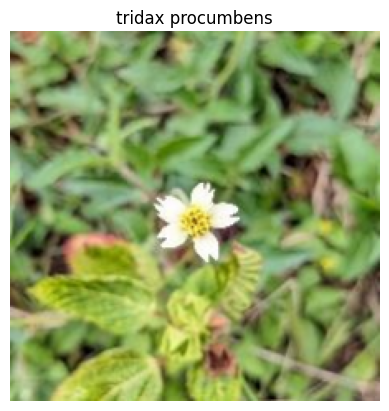

In [ ]:
image_batch, label_batch = next(iter(train_loader))

image,label=image_batch[0],label_batch[0]

print(f'Image shape: {image.shape}')
print(f'Label: {label}')

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        super().__init__()
        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels=in_channels,out_channels= emb_size, kernel_size=patch_size, stride=patch_size,padding=0)

        self.flatten = nn.Flatten(start_dim=2,end_dim=3)

    def forward(self, x):
        image_resolution  = x.shape[-1]
        assert image_resolution % self.patch_size ==0, f"Input image size must be divisible by patch size,image shape :{image_resolution}"

        x_patched= self.patcher(x)
        x_flattend = self.flatten(x_patched)

        return x_flattend.permute(0,2,1)

In [ ]:
patch_size =16

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds()

patchify=PatchEmbedding(in_channels=3,patch_size=16,emb_size=768)

print(f'Input Image shape :{image.unsqueeze(0).shape}')
patch_embedded_image= patchify(image.unsqueeze(0))
print(f'Output Patch Embedded Image shape :{patch_embedded_image.shape}')

Input Image shape :torch.Size([1, 3, 224, 224])
Output Patch Embedded Image shape :torch.Size([1, 196, 768])


In [ ]:
set_seeds()

patch_size=16

print(f'Image tensor shape: {image.shape}')
height,width = image.shape[1], image.shape[2]

x=image.unsqueeze(0)
print(f'Input Image shape: {x.shape}')

patch_embed = PatchEmbedding(in_channels=3, patch_size=patch_size, emb_size=768)
patch_embedded_image = patch_embed(x)
print(f'Patching embedding shape:{patch_embedded_image.shape}')

## create class token embedding
batch_size= patch_embedded_image.shape[0]
embedding_dimension= patch_embedded_image.shape[-1]
class_token= nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
print(f'Class token shape: {class_token.shape}')


## prepend class token embedding to patch embedding
patch_embedded_class_token=torch.cat([class_token,patch_embedded_image],dim=1)
print(f'Patched embedded class token shape: {patch_embedded_class_token.shape}')

## create position embedding
number_of_patches = int ((height* width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)

##ADD position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedded_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

print(patch_embedded_class_token)

Image tensor shape: torch.Size([3, 224, 224])
Input Image shape: torch.Size([1, 3, 224, 224])
Patching embedding shape:torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patched embedded class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5864,  0.1708, -0.1131,  ...,  0.4493, -0.2911,  0.1828],
         [-0.5225,  0.1577, -0.1518,  ...,  0.3828, -0.2907,  0.2589],
         ...,
         [-0.3185,  0.1641, -0.2403,  ...,  0.3652, -0.2643,  0.2368],
         [-0.5840,  0.2077, -0.0798,  ...,  0.4635, -0.3372,  0.1447],
         [-0.7071,  0.0976, -0.1126,  ...,  0.4577, -0.2894,  0.2122]]],
       grad_fn=<CatBackward0>)


In [ ]:
## create class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,embedding_dimension: int=768, num_heads: int=12, attn_dropout: float=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(embedding_dimension)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dimension,num_heads=num_heads,dropout=attn_dropout,batch_first= True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attention(query=x,
                                                key=x,
                                               value=x,
                                               need_weights=False)
        return attn_output

In [ ]:
## MLP block
class MLPBlock(nn.Module):
    def __init__(self,embedding_dimension: int=768, mlp_dimension: int=3072, dropout: float=0.1):
        super().__init__()

        self.layer_norm= nn.LayerNorm(normalized_shape=embedding_dimension)

        self.mlp=nn.Sequential(
            nn.Linear(in_features=embedding_dimension,out_features=mlp_dimension),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_dimension,out_features=embedding_dimension),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
## Creating a Transformer encoder by combining our custom made layers

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dimension: int=768, num_heads: int=12, mlp_dimension: int=3072, mlp_dropout: float=0.1,attn_dropout: float=0):
        super().__init__()
    ## create MSA block
        self.msa_block= MultiheadSelfAttentionBlock(embedding_dimension=embedding_dimension,num_heads=num_heads,attn_dropout=attn_dropout)
    ## create MLP block
        self.mlp_block= MLPBlock(embedding_dimension=embedding_dimension,mlp_dimension=mlp_dimension,dropout=mlp_dropout)

    def forward(self, x):
        x = x + self.msa_block(x)
        x = x + self.mlp_block(x)
        return x

In [ ]:
%pip install torchinfo

In [ ]:
## Transformer encoder block created

transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

In [ ]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              emb_size=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dimension=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_dimension=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
# Train our MOdel

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/')
from going_modular.going_modular import engine
from torch.utils.data import DataLoader

# Assuming train_dataset, val_dataset, and test_dataset are your datasets
train_dataloader = train_loader
val_dataloader = valid_loader
test_dataloader = test_loader

# Setup the optimizer to optimize our model parameters
optimizer = torch.optim.AdamW(params=vit.parameters(), lr=3e-4, betas=(0.9, 0.999), weight_decay=0.01)


# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3965 | train_acc: 0.0644 | val_loss: 3.0595 | val_acc: 0.1030 | test_loss: 3.0593 | test_acc: 0.0994
Epoch: 2 | train_loss: 2.6786 | train_acc: 0.1940 | val_loss: 2.2014 | val_acc: 0.3164 | test_loss: 2.1317 | test_acc: 0.2997
Epoch: 3 | train_loss: 1.9022 | train_acc: 0.3752 | val_loss: 1.5484 | val_acc: 0.5143 | test_loss: 1.4734 | test_acc: 0.5205
Epoch: 4 | train_loss: 1.4744 | train_acc: 0.5164 | val_loss: 1.4939 | val_acc: 0.5088 | test_loss: 1.5632 | test_acc: 0.4971
Epoch: 5 | train_loss: 1.2625 | train_acc: 0.5728 | val_loss: 1.1146 | val_acc: 0.6242 | test_loss: 1.0393 | test_acc: 0.6389
Epoch: 6 | train_loss: 1.1622 | train_acc: 0.6086 | val_loss: 1.0118 | val_acc: 0.6676 | test_loss: 1.0195 | test_acc: 0.6550
Epoch: 7 | train_loss: 1.0083 | train_acc: 0.6655 | val_loss: 0.8949 | val_acc: 0.6860 | test_loss: 0.8522 | test_acc: 0.7135
Epoch: 8 | train_loss: 0.8763 | train_acc: 0.6977 | val_loss: 1.0152 | val_acc: 0.6574 | test_loss: 0.9982 | test_acc:

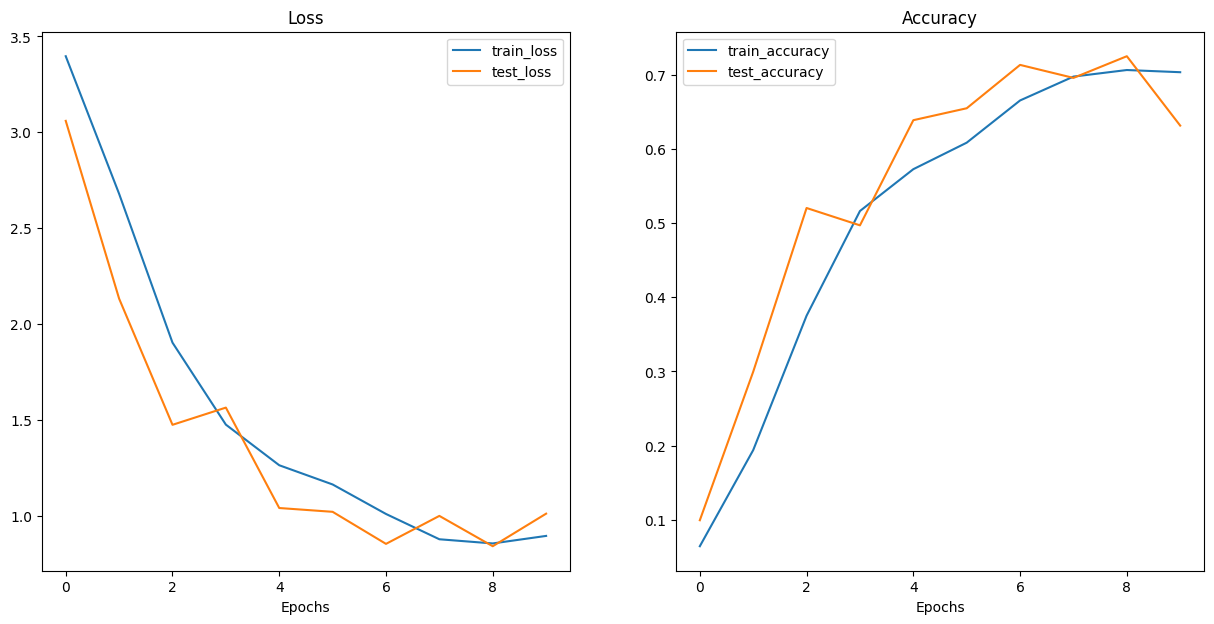

In [ ]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
import sys
sys.path.append('/content/drive/MyDrive/')
from going_modular.going_modular.helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

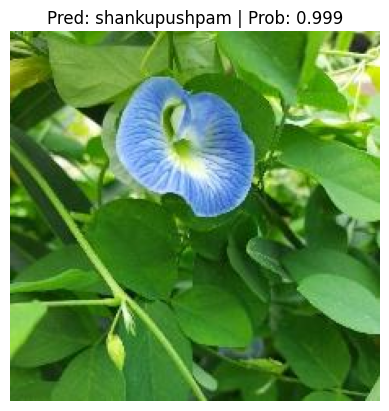

In [ ]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
import sys
sys.path.append('/content/drive/MyDrive/')
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_img2.jpg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)